This notebook fits a BiLSTM for Twitter Corpus.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
EMBEDDING_FILE = '../datasets/glove.twitter.27B.200d.txt'

In [3]:
# Suppose `texts` is a list of sentences.
data = pd.read_csv("../datasets/sarcasm_subset.csv")
data = data.sample(n=1000)

In [4]:
data.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [5]:
data["text"] = data["parent_comment"] + data["comment"]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 23563 to 16
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           1000 non-null   int64 
 1   comment         1000 non-null   object
 2   author          1000 non-null   object
 3   subreddit       1000 non-null   object
 4   score           1000 non-null   int64 
 5   ups             1000 non-null   int64 
 6   downs           1000 non-null   int64 
 7   date            1000 non-null   object
 8   created_utc     1000 non-null   object
 9   parent_comment  1000 non-null   object
 10  text            1000 non-null   object
dtypes: int64(4), object(7)
memory usage: 126.0+ KB


In [15]:
texts = data["text"].tolist()
labels = data["label"].values

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Use a fixed value for `maxlen` based on your data's requirements
maxlen = 200  # for example
data = pad_sequences(sequences, maxlen=maxlen)

# Convert the labels to a numpy array
labels = np.array(labels)


In [17]:
embedding_index = {}
with open(EMBEDDING_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs


In [18]:
word_index = tokenizer.word_index
embedding_dim = 200 # Size of the GloVe vectors.
vocab_size = len(word_index) + 1  # Adding 1 because index 0 is reserved

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector


In [26]:

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen, 
                    weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 200)          1349600   
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               135680    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1485409 (5.67 MB)
Trainable params: 135809 (530.50 KB)
Non-trainable params: 1349600 (5.15 MB)
_________________________________________________________________


In [27]:


history = model.fit(data,labels, batch_size=128, epochs=9, validation_split=0.2)


Epoch 1/9
7/7 [==============================] - 9s 1s/step - loss: 0.6936 - accuracy: 0.5038 - val_loss: 0.6889 - val_accuracy: 0.5350
Epoch 2/9
7/7 [==============================] - 7s 1s/step - loss: 0.6759 - accuracy: 0.5838 - val_loss: 0.6842 - val_accuracy: 0.5300
Epoch 3/9
7/7 [==============================] - 7s 1s/step - loss: 0.6616 - accuracy: 0.6837 - val_loss: 0.6780 - val_accuracy: 0.5950
Epoch 4/9
7/7 [==============================] - 8s 1s/step - loss: 0.6474 - accuracy: 0.7125 - val_loss: 0.6729 - val_accuracy: 0.5850
Epoch 5/9
7/7 [==============================] - 7s 1s/step - loss: 0.6322 - accuracy: 0.6875 - val_loss: 0.6673 - val_accuracy: 0.5900
Epoch 6/9
7/7 [==============================] - 7s 1s/step - loss: 0.6086 - accuracy: 0.7088 - val_loss: 0.6649 - val_accuracy: 0.6100
Epoch 7/9
7/7 [==============================] - 7s 1s/step - loss: 0.5849 - accuracy: 0.7175 - val_loss: 0.6564 - val_accuracy: 0.6100
Epoch 8/9
7/7 [==============================] -

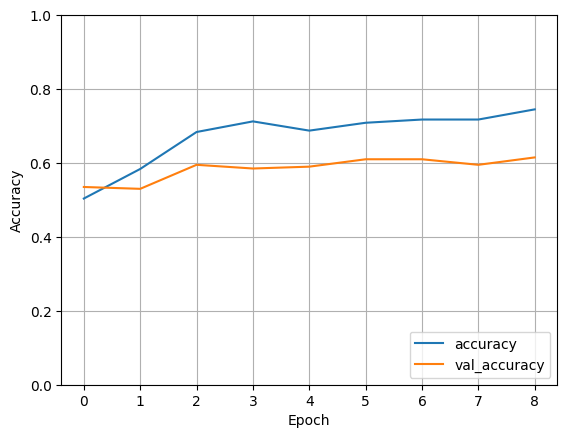

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

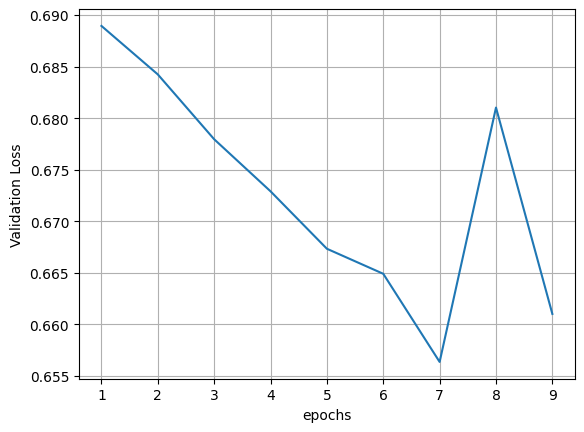

In [29]:
losses = history.history["val_loss"]
plt.plot(range(1,10), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()

Accuracy: 62%